# Project

In [1]:
import numpy as np
import math
import time
from computer_vision import *
from dijkstra import compute_shortest_path
from kalman import kalman_ext_filter
import tdmclient.notebook
await tdmclient.notebook.start()


In [2]:
# parametres
speed_r = 100
time_rotation = 7*speed_r/125
speed_f = 100
stop = 0
MIN_DIST = 40
ANGLE_TOLERANCE = 0.30
PERIOD = 0.005
SPEED_AVG = 150
ROBOT_SPEED_TO_MM = 140/500

@tdmclient.notebook.sync_var
def motors(l_speed=500, r_speed=500):
    global motor_left_target, motor_right_target
    
    motor_left_target = l_speed
    motor_right_target = r_speed

def get_angle_between(vec1, vec2):
    vec1_unit = vec1 / np.linalg.norm(vec1)
    vec2_unit = vec2 / np.linalg.norm(vec2)

    return np.arccos(np.dot(vec1_unit, vec2_unit))

def distance (x1, y1, x2, y2):
    dist = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    return dist

def wrap_angle(angle):
    if angle > math.pi:
        angle = angle - 2*math.pi
    elif angle < -math.pi:
        angle = angle + 2*math.pi
    return angle

In [3]:
def controller(goal_dist, angle):
    kp_rot = 100
    kp_lin = 3

    if abs(angle) > ANGLE_TOLERANCE:
        speed_l = 80 - kp_rot*(angle)
        speed_r = 80 + kp_rot*(angle)

    else:
        speed_l = SPEED_AVG
        speed_r = SPEED_AVG
    return speed_l, speed_r

In [4]:
def pathing (video_capture, filter, path, x0, y0, theta0, periode=0.01):
    teta = np.zeros(np.shape(path)[0])
    speed_l = speed_r = 0
    goalx = path[0][0]
    goaly = path[0][1]
    
    i = 0
    x_pense = x0
    y_pense = y0
    curr_time = 0
    
    kx = kteta = ky = angle = 0
    robot_detected = False
    camera_available = False
    dist = distance (goalx, goaly, kx, ky)
    while True:       
        #   step 1: get the image, detect the robot, and get the position
        camera_available, frame = video_capture.read()
        position_measure = []
        if camera_available == True:
            position_measure, position_contour, proccessed_framed = computer_vision(frame, 'robot', False)
            # cv has detected the robot, we can use the position
            if len(position_measure) == 1:
                robot_detected = True
                position_measure = position_measure[0]

                if position_measure is not None:                    
                    _, theta_measure = get_robot_position(frame, position_measure, position_contour)
                    
                    position_measure = invert_coordinates(position_measure)
                    position_measure[0:2] = pixel_to_metric(position_measure[0:2])

                    [kx, ky, kteta] = [position_measure[0], position_measure[1], -theta_measure]
                    measurement = np.array([kx, ky, kteta])
                else:
                    robot_detected = False
            else:
            # robot not detected, we use kalman
                robot_detected = False

        if camera_available == False or robot_detected == False:
            measurement = np.array([0,0,0])         # CHECK WHY 0,0,0            
        
        [pred_x, pred_y, pred_teta], _, curr_time = filter.filter(measurement, curr_time) 
        
        dist = distance (goalx, goaly, kx, ky)
        teta[i] = math.atan2((goaly - ky), (goalx - kx)) #change angle according to kalman
    

        if (dist < MIN_DIST):
            if i < np.shape(path)[0] - 1 :
                i = i + 1
                goalx = path[i][0]
                goaly = path[i][1]
                x_pense = path[i-1][0]
                y_pense = path[i-1][1]
                vec1 = [np.cos(teta[i-1]), np.sin(teta[i-1])]
                vec2 = [goalx - x_pense, goaly - y_pense]
                angle = get_angle_between(vec1, vec2)
            else:
                motors(stop, stop)
                break
        else :
            x_pense = kx + speed_f * periode * np.cos(teta[i]) #à update
            y_pense = ky + speed_f * periode * np.sin(teta[i])
            angle =  wrap_angle((teta[i] - kteta) % (2*np.pi))
            
            speed_l, speed_r = controller(dist, angle)
            #speed_l  = SPEED_AVG
            #speed_r = SPEED_AVG
        
        # set input for kalman filter
        filter.u = np.array([speed_l, speed_r]) * ROBOT_SPEED_TO_MM

        motors(int(speed_l),int(speed_r))

        controller(dist,angle)
        #print(i, camera_available, dist, position_measure, angle, teta[i], kteta)
        
        print("camera : %.3f %.3f %.4f" %(kx, ky, kteta))
        print("kalman : %.3f %.3f %.4f" %(pred_x, pred_y, pred_teta))
        #cv2.imshow("frame", cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    motors(stop, stop)

# Main 

1
2
3
start = [ 68. 340.] goal = [856.  646.4]
path = [[ 68.  340. ]
 [175.2 256. ]
 [440.8 260. ]
 [520.  532. ]
 [673.6 712. ]
 [680.8 581.6]
 [856.  646.4]]
845.4732166071259


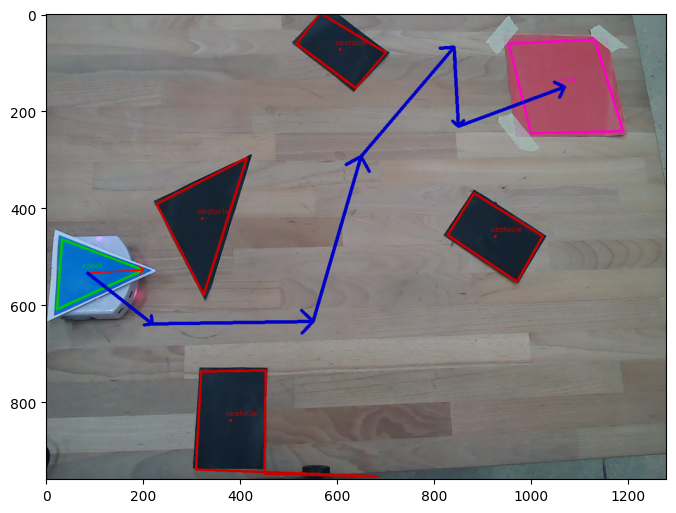

In [5]:
video_capture = cv2.VideoCapture(0,cv2.CAP_DSHOW)
fig, ax = plt.subplots(figsize=(8,8))
cv_successful, obst, robot, goal, frame = cv_start(video_capture, show_image= True, exposure=-7)

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
obst = format_contour(obst)

if cv_successful:
    start = np.array([robot[0], robot[1]])
    goal = np.array([goal[0], goal[1]])
    path = compute_shortest_path(obst, start, goal)
    path = np.rint(path).astype(int)
    frame = draw_path(frame, path) 
        
    metric_path = np.zeros(np.shape(path))

    # invert y axis
    for i in range(len(path)):
        path[i] = invert_coordinates(path[i])
    metric_start = invert_coordinates(start)
    metric_goal = invert_coordinates(goal)
    # change to metric  

    for i in range(len(path)):
        metric_path[i] = pixel_to_metric(path[i])
    metric_start = pixel_to_metric(metric_start)
    metric_goal = pixel_to_metric(metric_goal)
    
    filter = kalman_ext_filter(metric_start[0], metric_start[1], robot[2], 0, 0 ,SPEED_AVG, PERIOD)
    print('start =', metric_start, 'goal =', metric_goal)
    print('path =', metric_path)

    print(distance(metric_start[0], metric_start[1], metric_goal[0], metric_goal[1]))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [6]:
#ret, frame = video_capture.read()
#print(ret)
#plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
#cv2.imwrite('frame.jpeg', frame)

motors(stop, stop)
np.shape(path)
print(np.shape(path)[0])

7


In [7]:
pathing(video_capture, filter, metric_path, metric_start[0], metric_start[1], robot[2], periode=PERIOD)
print("finished")
motors(stop, stop)

camera : 68.000 340.000 0.0603
kalman : 68.000 340.000 0.0603
camera : 68.800 340.000 0.0608
kalman : 68.544 339.993 0.0605
camera : 68.000 340.800 0.0517
kalman : 80.144 339.652 0.0561
camera : 68.000 340.000 0.0603
kalman : 84.512 339.356 0.0556
camera : 72.800 338.400 -0.0174
kalman : 89.214 338.801 0.0393
camera : 79.200 335.200 -0.1407
kalman : 95.068 337.811 0.0077
camera : 84.800 329.600 -0.2663
kalman : 100.883 336.262 -0.0328
camera : 91.200 324.800 -0.4164
kalman : 107.165 334.441 -0.0819
camera : 97.600 317.600 -0.5236
kalman : 124.303 331.629 -0.1310
camera : 102.400 312.800 -0.5954
kalman : 133.651 329.149 -0.1774
camera : 111.200 306.400 -0.6151
kalman : 142.771 326.504 -0.2172
camera : 120.800 298.400 -0.6027
kalman : 152.358 323.571 -0.2493
camera : 132.800 288.800 -0.6151
kalman : 163.684 320.233 -0.2775
camera : 143.200 282.400 -0.6172
kalman : 174.521 316.894 -0.3017
camera : 153.600 274.400 -0.6172
kalman : 185.226 313.435 -0.3228
camera : 163.200 266.400 -0.6050
ka